In [1]:
import os
from pathlib import Path

from torch.autograd import Variable
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import albumentations as albu
import numpy as np
import cv2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

import config as cfg

/home/shung/miniconda3/envs/STAS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
OUTPUT_PATH = "./OpenVINO"
BASE_MODEL_NAME = OUTPUT_PATH + "/Deeplabv3P_resnet50_batch16"

IMAGE_WIDTH = 1600
IMAGE_HEIGHT = 800
DEVICE='cuda'

In [3]:
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

# Paths where PyTorch, ONNX and OpenVINO IR models will be stored.
model_path = Path(BASE_MODEL_NAME).with_suffix(".pth")
onnx_path = model_path.with_suffix(".onnx")
ir_path = model_path.with_suffix(".xml")

In [4]:
dummy_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH).to(DEVICE)
model = torch.load('./Models/Deeplabv3P_resnet50_batch16.pth')
model.eval()
torch.onnx.export(model.module, dummy_input, onnx_path, verbose=True, )

Exported graph: graph(%input.1 : Float(1, 3, 800, 1600, strides=[3840000, 1280000, 1600, 1], requires_grad=0, device=cuda:0),
      %decoder.aspp.0.convs.1.0.0.weight : Float(2048, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %decoder.aspp.0.convs.2.0.0.weight : Float(2048, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %decoder.aspp.0.convs.3.0.0.weight : Float(2048, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %decoder.aspp.1.0.weight : Float(256, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %decoder.block2.0.0.weight : Float(304, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %segmentation_head.0.weight : Float(1, 256, 1, 1, strides=[256, 1, 1, 1], requires_grad=1, device=cuda:0),
      %segmentation_head.0.bias : Float(1, strides=[1], requires_grad=1, device=cuda:0),
      %onnx::Conv_617 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cuda:

In [5]:
mo_cmd = f"""mo
            --input_model "{onnx_path}"
            --input_shape "[1, 3, {IMAGE_HEIGHT}, {IMAGE_WIDTH}]"
            --data_type FP16
            --output_dir "{OUTPUT_PATH}"
            """
mo_cmd = " ".join(mo_cmd.split())
print("Model Optimizer command to convert the ONNX model to OpenVINO:")
display(Markdown(f"`{mo_cmd}`"))

Model Optimizer command to convert the ONNX model to OpenVINO:


`mo --input_model "OpenVINO/Deeplabv3P_resnet50_batch16.onnx" --input_shape "[1, 3, 800, 1600]" --data_type FP16 --output_dir "./OpenVINO"`

In [6]:
if not ir_path.exists():
    print("Exporting ONNX model to IR... This may take a few minutes.")
    mo_result = %sx $mo_cmd
    print("\n".join(mo_result))
    print("DONE")
else:
    print(f"IR model {ir_path} already exists.")

IR model OpenVINO/Deeplabv3P_resnet50_batch16.xml already exists.


# Show Results

In [4]:
def normalize(image: np.ndarray, input_range=[0, 1], mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) -> np.ndarray:
    # image = image.astype(np.float32)
    if input_range is not None:
        if image.max() > 1 and input_range[1] == 1:
            image = image / 255.0

    if mean is not None:
        mean = np.array(mean)
        image = image - mean

    if std is not None:
        std = np.array(std)
        image = image / std
    return image

In [5]:
image_filename = cfg.INFERENCE_IMAGE_DIR + "/Private_00000045.jpg"
image = cv2.cvtColor(cv2.imread(image_filename), cv2.COLOR_BGR2RGB)

resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
normalized_image = normalize(resized_image)

# Convert the resized images to network input shape.
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0).astype(float)
normalized_input_image = np.expand_dims(np.transpose(normalized_image, (2, 0, 1)), 0).astype(float)

# Load the OpenVINO IR Network and Run Inference on the ONNX model

1. ONNX Model in OpenVINO Runtime

In [6]:
from openvino.runtime import Core

In [7]:
# Load the network to OpenVINO Runtime.
ie = Core()
model_onnx = ie.read_model(model=onnx_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

output_layer_onnx = compiled_model_onnx.output(0)

# Run inference on the input image.
res_onnx = compiled_model_onnx([normalized_input_image])[output_layer_onnx]

In [21]:
# Convert the network result to a segmentation map and display the result.
# result_mask_onnx = np.squeeze(np.argmax(res_onnx, axis=1)).astype(np.uint8)
result_mask_onnx = np.squeeze(res_onnx).round()

In [23]:
zeros = np.zeros((800, 1600, 3))
zeros[...,0] = result_mask_onnx
zeros[...,1] = result_mask_onnx
zeros[...,2] = result_mask_onnx
zeros = cv2.resize(zeros, (1716, 942))

True

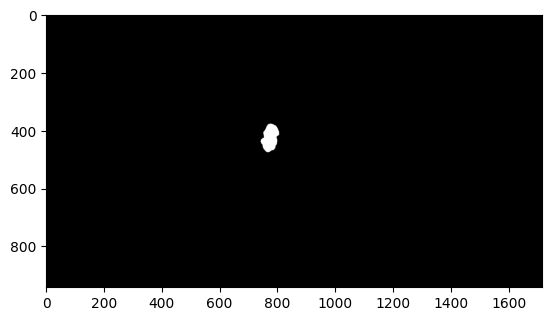

In [24]:
plt.imshow(zeros)
cv2.imwrite("result.jpg", zeros)

In [30]:
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: 12th Gen Intel(R) Core(TM) i7-12700


# torch output

(1, 3, 800, 1600)
torch.Size([1, 1, 800, 1600])
(800, 1600)


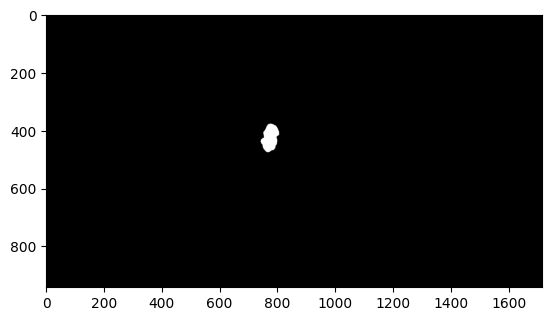

In [16]:
# best_model= torch.load('./Models/Deeplabv3P_resnet50_batch16_new_aug_SAM_epoch200_ori.pth')
best_model = torch.load(os.path.join(cfg.MODEL_DIR, "Deeplabv3P_resnet50_batch16.pth"))
best_model.eval()

x_tensor = torch.from_numpy(normalized_input_image).to(DEVICE)

with torch.no_grad():
    pr_mask = best_model(x_tensor.float())
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
zeros = np.zeros((800, 1600, 3))
zeros[...,0] = pr_mask
zeros[...,1] = pr_mask
zeros[...,2] = pr_mask
zeros = cv2.resize(zeros, (1716, 942))
plt.imshow(zeros)